In [17]:
import os
import re
import math
import glob
import wfdb
import time
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo

from ray import tune, put, get
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

from scipy import signal
from torch.utils.data import Dataset, DataLoader, Subset
from skimage.restoration import denoise_wavelet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [18]:
def mse(signal_clean, signal_noisy):
    return mean_squared_error(signal_clean, signal_noisy)

def mae(signal_clean, signal_noisy):
    return mean_absolute_error(signal_clean, signal_noisy)

def rmse(signal_clean, signal_noisy):
    return np.sqrt(mse(signal_clean, signal_noisy))

def snr(signal_clean, signal_noisy):
    return 10 * np.log10(np.sum(signal_clean ** 2) / (np.sum((signal_noisy - signal_clean) ** 2)))

def psnr(signal_clean, signal_noisy):
    return 20 * np.log10(np.max(signal_clean) / rmse(signal_clean, signal_noisy))

def prd(signal_clean, signal_noisy):
    return np.sqrt(np.sum((signal_clean - signal_noisy) ** 2) / np.sum(signal_clean ** 2)) * 100

def xcorr(signal_clean, signal_noisy):
    return np.mean(np.correlate(signal_clean, signal_noisy, mode='full'))

In [19]:
def load_cebs(directory):
    record = wfdb.rdsamp(directory)
    data = record[0]
    metadata = record[1]

    frequency = metadata['fs']
    column_names = metadata['sig_name']
    length = metadata['sig_len']

    data = pd.DataFrame(data, columns=column_names)
    data.drop(['I', 'II', 'RESP'], axis=1, inplace=True)

    frequency_string = str(int(1/frequency*1000000)) + 'U'
    index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    data.set_index(index, inplace=True)
    data = data.resample(sampling_rate).mean().SCG

    data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
    data = data[data.apply(lambda x: len(x) == segment_size_samples)]
    data = data.apply(lambda x: np.array(x))
    
    return data


def load_d2(directory):

    regex_up_1 = re.compile(r'./data/D2/UP-(((0|1)[0-9])|(20|21))-*')
    regex_up_2 = re.compile(r'./data/D2/UP-(22|23)-*')

    if re.match(r'./data/D2/CP-*', directory):
        data = pd.read_csv(directory, 
                sep=',', 
                header=1, 
                skiprows=[2],
                usecols=['Shimmer_D0CD_Timestamp_Shimmer_CAL', 'Shimmer_D0CD_Accel_LN_Z_CAL'], 
                dtype={'Shimmer_D0CD_Timestamp_Shimmer_CAL': 'float', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'float'})
        data.rename(columns={'Shimmer_D0CD_Timestamp_Shimmer_CAL': 'index', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
    elif regex_up_1.match(directory):
        data = pd.read_csv(directory, 
                sep='	', 
                header=1, 
                skiprows=[2],
                usecols=['ECG_TimestampSync_Unix_CAL', 'ECG_Accel_LN_Z_CAL'], 
                dtype={'ECG_TimestampSync_Unix_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
        data.rename(columns={'ECG_TimestampSync_Unix_CAL': 'index', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
    elif regex_up_2.match(directory):
        data = pd.read_csv(directory, 
                sep=',', 
                header=1, 
                skiprows=[2],
                usecols=['ECG_Timestamp_Unix_CAL', 'ECG_Accel_LN_Z_CAL'], 
                dtype={'ECG_Timestamp_Unix_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
        data.rename(columns={'ECG_Timestamp_Unix_CAL': 'index', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
    elif re.match(r'./data/D2/UP-*', directory):
        data = pd.read_csv(directory, 
                sep=',', 
                header=0, 
                skiprows=[1],
                usecols=['ECG_Accel_LN_Z_CAL'], 
                dtype={'ECG_Accel_LN_Z_CAL': 'float'})
        data.rename(columns={'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)

        # The datetime index is not set correctly, thus set manually
        frequency_string = str(int(1/512*1000000000)) + 'N'
        data['index'] = pd.date_range(start='1/1/1970', periods=data.shape[0], freq=frequency_string)
    else:
        return pd.DataFrame()

    data['index'] = pd.to_datetime(data['index'], unit='ms')
    data.set_index('index', inplace=True)

    data = data.resample(sampling_rate).mean().SCG

    data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
    data = data[data.apply(lambda x: len(x) == segment_size_samples and not np.isnan(x).any())]
    data = data.apply(lambda x: np.array(x))

    return data

In [20]:
def load_datasets(directory, datasets):

    data = pd.Series(dtype='object')

    if 'CEBS' in datasets:
        filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(r'./data/CEBS/*[0-9][0-9][0-9].*')]))
        data = pd.concat((load_cebs(filename) for filename in filenames), ignore_index=True)
    if 'D2' in datasets:
        filenames = glob.glob(r'./data/D2/*')
        data2 = pd.concat((load_d2(filename) for filename in filenames), ignore_index=True)
        data = pd.concat((data, data2))

    return data

In [21]:
def normalize(clean, noise):
    x_concat = np.concatenate((clean, noise))
    min_val = np.min(x_concat)
    max_val = np.max(x_concat)
    y_clean = (clean-min_val) / (max_val - min_val)
    y_noise = (noise-min_val) / (max_val - min_val)
    return y_clean, y_noise, min_val, max_val

# SCG dependent on absolute values
def denormalize(clean, noise, min_val, max_val):
    y_clean = max_val * clean - clean * min_val + min_val
    y_noise = max_val * noise - noise * min_val + min_val
    return y_clean, y_noise


def bandpass(input_signal):
    # https://www.youtube.com/watch?v=juYqcck_GfU
    fs = 100.0 # frequency space
    lowcut = 5.0 # Hz
    highcut = 30.0 # Hz

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    order = 4

    b, a, = signal.butter(order, [low, high], 'bandpass', analog=False)
    y = signal.filtfilt(b, a, input_signal, axis=0)

    return y

# Dataset

This is a utilitarian class which is used for managing the required data. It inherits from the PyTorch `Dataset` class, which provides tools like splitting the data into train and test subsets or using it in dataloaders to efficiently access the data. The dataset for this experiment coprises the CEBS dataset and another dataset, called D2. The data from the denoted datasets will be loaded directly when initialising an object of the class. Each dataset will be imported, depending on its specific characteristics, the schemas will be normalized, the two dataset will be resampled and each dataset will be grouped according to `segment_size_samples`. Subsequelty, the two datasets will be combined. Initially, no noise will be added to the data, i.e. the clean and noisy data will be the same in the beginning. This is done so that training and testing can be done with different noise levels. The noise generated is gaussian white noise. However, this can be substituted with some other noise generation mechanism later, when required. Please note that the code for generating the noise was adopted from [this](https://stackoverflow.com/a/53688043) example.

In [31]:
class SCGData(Dataset):

    def __init__(self, directory=None, datasets=None, transform=None):

        self.directory = directory
        self.datasets = datasets
        self.transform = transform

        data = self.__load_datasets()

        # data = data.apply(lambda x: bandpass(x))
        data = pd.DataFrame({'clean': data, 'noise': data})
        
        self.x_data = data.noise.values
        self.y_data = data.clean.values

        self.n_samples = data.shape[0]


    def add_noise(self, target_snr_dbs):
        self.x_data = np.array([self.__add_gaussian(inputs, target_snr_dbs) for inputs in self.y_data])


    def __add_gaussian(self, data, target_snr_dbs):

        # target_snr_db = random.choices(target_snr_dbs, weights=target_snr_weights, k=1)[0]
        target_snr_db = random.choice(target_snr_dbs)
        # target_snr_db = random.uniform(-1, 20) # sample from bigger range provides better results?
        # target_snr_db = 1

        data_watts = data ** 2
        data_avg_watts = np.mean(data_watts)
        data_avg_db = 10 * np.log10(data_avg_watts)

        noise_avg_db = data_avg_db - target_snr_db
        noise_avg_watts = 10 ** (noise_avg_db / 10)

        mean_noise = 0
        noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data_watts))

        data_noisy = data + noise
        return data_noisy


    def __load_cebs(self, filename):
        record = wfdb.rdsamp(filename)
        data = record[0]
        metadata = record[1]

        frequency = metadata['fs']
        column_names = metadata['sig_name']
        length = metadata['sig_len']

        data = pd.DataFrame(data, columns=column_names)
        data.drop(['I', 'II', 'RESP'], axis=1, inplace=True)

        frequency_string = str(int(1/frequency*1000000)) + 'U'
        index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
        data.set_index(index, inplace=True)
        data = data.resample(sampling_rate).mean().SCG

        data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
        data = data[data.apply(lambda x: len(x) == segment_size_samples)]
        data = data.apply(lambda x: np.array(x))
        
        return data


    def __load_d2(self, filename):

        regex_up_1 = re.compile(r'./data/D2/UP-(((0|1)[0-9])|(20|21))-*')
        regex_up_2 = re.compile(r'./data/D2/UP-(22|23)-*')

        if re.match(r'./data/D2/CP-*', filename):
            data = pd.read_csv(filename, 
                    sep=',', 
                    header=1, 
                    skiprows=[2],
                    usecols=['Shimmer_D0CD_Timestamp_Shimmer_CAL', 'Shimmer_D0CD_Accel_LN_Z_CAL'], 
                    dtype={'Shimmer_D0CD_Timestamp_Shimmer_CAL': 'float', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'Shimmer_D0CD_Timestamp_Shimmer_CAL': 'index', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
        elif regex_up_1.match(filename):
            data = pd.read_csv(filename, 
                    sep='	', 
                    header=1, 
                    skiprows=[2],
                    usecols=['ECG_TimestampSync_Unix_CAL', 'ECG_Accel_LN_Z_CAL'], 
                    dtype={'ECG_TimestampSync_Unix_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'ECG_TimestampSync_Unix_CAL': 'index', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
        elif regex_up_2.match(filename):
            data = pd.read_csv(filename, 
                    sep=',', 
                    header=1, 
                    skiprows=[2],
                    usecols=['ECG_Timestamp_Unix_CAL', 'ECG_Accel_LN_Z_CAL'], 
                    dtype={'ECG_Timestamp_Unix_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'ECG_Timestamp_Unix_CAL': 'index', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
        elif re.match(r'./data/D2/UP-*', filename):
            data = pd.read_csv(filename, 
                    sep=',', 
                    header=0, 
                    skiprows=[1],
                    usecols=['ECG_Accel_LN_Z_CAL'], 
                    dtype={'ECG_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)

            # The datetime index is not set correctly, thus set manually
            frequency_string = str(int(1/512*1000000000)) + 'N'
            data['index'] = pd.date_range(start='1/1/1970', periods=data.shape[0], freq=frequency_string)
        else:
            return pd.DataFrame()

        data['index'] = pd.to_datetime(data['index'], unit='ms')
        data.set_index('index', inplace=True)

        data = data.resample(sampling_rate).mean().SCG

        data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
        data = data[data.apply(lambda x: len(x) == segment_size_samples and not np.isnan(x).any())]
        data = data.apply(lambda x: np.array(x))

        return data


    def __load_datasets(self):

        data = pd.Series(dtype='object')

        if 'CEBS' in self.datasets:
            directory = os.path.join(self.directory, 'CEBS')
            filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(f'{directory}/*[0-9][0-9][0-9].*')]))
            data = pd.concat((self.__load_cebs(filename) for filename in filenames), ignore_index=True)
        if 'D2' in self.datasets:
            directory = os.path.join(self.directory, 'D2')
            filenames = glob.glob(f'{directory}/*')
            data2 = pd.concat((self.__load_d2(filename) for filename in filenames), ignore_index=True)
            data = pd.concat((data, data2))

        return data


    def __getitem__(self, index):
        sample = self.x_data[index].copy(), self.y_data[index].copy()

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    
    def __len__(self):
        return self.n_samples


class ToTensor:

    def __call__(self, sample):
        inputs, targets = sample
        return torch.Tensor(inputs), torch.Tensor(targets)

['./data/CEBS/b017', './data/CEBS/p009', './data/CEBS/p010', './data/CEBS/b006', './data/CEBS/m009', './data/CEBS/p012', './data/CEBS/p013', './data/CEBS/b009', './data/CEBS/p001', './data/CEBS/b010', './data/CEBS/m017', './data/CEBS/m011', './data/CEBS/m004', './data/CEBS/b003', './data/CEBS/p002', './data/CEBS/b011', './data/CEBS/b020', './data/CEBS/m013', './data/CEBS/m015', './data/CEBS/m006', './data/CEBS/p020', './data/CEBS/p011', './data/CEBS/b004', './data/CEBS/p014', './data/CEBS/b015', './data/CEBS/b005', './data/CEBS/b019', './data/CEBS/p006', './data/CEBS/p007', './data/CEBS/b001', './data/CEBS/m008', './data/CEBS/p017', './data/CEBS/m005', './data/CEBS/m018', './data/CEBS/b008', './data/CEBS/b013', './data/CEBS/b014', './data/CEBS/b016', './data/CEBS/m019', './data/CEBS/m007', './data/CEBS/p003', './data/CEBS/m012', './data/CEBS/b012', './data/CEBS/m016', './data/CEBS/b018', './data/CEBS/p005', './data/CEBS/p019', './data/CEBS/m003', './data/CEBS/b002', './data/CEBS/p004',

In [23]:
def load_data():
    dataset = SCGData(directory='./data/', datasets=['CEBS', 'D2'], transform=ToTensor())
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])

In [24]:
class DeNoise1(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise1, self).__init__()

        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.encoder = nn.Sequential(
            nn.Conv1d(1, layer_size, 3, stride=1),
            nn.BatchNorm1d(layer_size),
            nn.ELU(),
            nn.Conv1d(layer_size, int(layer_size/4), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), int(layer_size/8), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/8)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/8), int(layer_size/16), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/16)),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(int(layer_size/16), int(layer_size/16), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/16)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/16), int(layer_size/8), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/8)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/8), int(layer_size/4), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size), 3, stride=1), 
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.Conv1d(int(layer_size), 1, 3, stride=1, padding='same'),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//8)
        #encoded = nn.functional.pad(encoded, (0, 0, 0, 0))
        decoded = self.decoder(encoded)
        return decoded

#print(segment_size_samples/2 + 7)
#print(segment_size_samples/(2*8) + 7)
# torchinfo.summary(DeNoise1(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

In [25]:
class DeNoise2(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise2, self).__init__()

        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.encoder = nn.Sequential(
            nn.Conv1d(1, layer_size, 8, stride=1),
            nn.BatchNorm1d(layer_size),
            nn.ELU(),
            nn.Conv1d(layer_size, int(layer_size/4), 8, stride=2, padding=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), int(layer_size/8), 8, stride=1, padding=1),
            nn.BatchNorm1d(int(layer_size/8)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/8), 1, 8, stride=1, padding=1),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, int(layer_size/8), 8, stride=1),
            nn.BatchNorm1d(int(layer_size/8)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/8), int(layer_size/4), 8, stride=2, padding=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size), 8, stride=1),
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size), 1, 8, stride=1), 
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Conv1d(1, 1, 8, stride=1, padding='same'),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#torchinfo.summary(DeNoise2(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

In [26]:
class DeNoiseNone(nn.Module):
    def __init__(self, kernel_size=16, filters_1=40, filters_2=20):
        super(DeNoiseNone, self).__init__()
        #self.p1 = segment_size_samples/2 + 7
        #self.p2 = segment_size_samples/64 + 7
        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.kernel_size = kernel_size
        self.filters_1 = filters_1
        self.filters_2 = filters_2

        self.encoder = nn.Sequential(
            nn.Conv1d(1, filters_1, kernel_size, stride=2),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, filters_2, kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_1, kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.ConvTranspose1d(1, filters_1, kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.ConvTranspose1d(filters_1, filters_2, kernel_size, stride=2, padding=0),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, padding=0),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, padding=0),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_1, kernel_size, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        # x = x.view(-1, 1, segment_size_samples)
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//16, 1)
        #encoded = nn.functional.pad(encoded, (0, 0, 1, 0))
        decoded = self.decoder(encoded)
        return decoded

# torchinfo.summary(DeNoiseNone(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

In [27]:
def train(config, train_dataset, model_num, is_tune=False, data_id=None, checkpoint_dir=None, data_dir=None):

    if model_num in [1]:
        model = DeNoise1(layer_size=config['layer_size'])
    elif model_num in [2, 3]:
        model = DeNoise2(layer_size=config['layer_size'])
    elif model_num in [4]:
        model = DeNoiseNone()
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['wd'])

    # if checkpoint_dir != None:
    #    model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
    #    model.load_state_dict(model_state)
    #    optimizer.load_state_dict(optimizer_state)

    if data_id:
        train_dataset = get(data_id)

    test_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - test_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [test_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)

    n_total_steps = len(train_loader)
    min_val_loss = np.inf

    train_loss_values = []
    val_loss_values = []
    epoch_values = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        epoch_steps = 0
        for i, (inputs, lables) in enumerate(train_loader):
            
            lables, inputs, _, _ = normalize(lables, inputs)

            if model_num == 3:
                inputs = denoise_wavelet(inputs, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                
            # inputs, lables = torch.from_numpy(inputs), torch.from_numpy(lables)
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, lables)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            epoch_steps += 1

        train_loss_values.append(train_loss)

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, (inputs, lables) in enumerate(val_loader):

            lables, inputs, _, _ = normalize(lables, inputs)

            if model_num == 3:
                inputs = denoise_wavelet(inputs, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')

            # inputs, lables = torch.from_numpy(inputs), torch.from_numpy(lables)
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            output = model(inputs)
            loss = criterion(output, lables)
            val_loss += loss.item()
            val_steps += 1
            
        val_loss_values.append(val_loss)
        epoch_values.append(epoch)

        if is_tune:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, 'checkpoint')
                torch.save((model.state_dict(), optimizer.state_dict()), path)
            
            tune.report(loss=(val_loss / val_steps))
        else:
            print(f'epoch {epoch + 1} / {num_epochs}, train loss = {(train_loss / len(train_loader)):.10f}, val loss = {(val_loss / len(val_loader)):.10f}')
            if min_val_loss > val_loss:
                print(f'\tval loss decreased from {min_val_loss:.10f} to {val_loss:.10f}')
                min_val_loss = val_loss

                if model_num == 1:
                    torch.save(model.state_dict(), os.path.join(model_directory, 'model_1.pth'))
                    df = pd.DataFrame({'epoch': epoch_values,'train_loss': train_loss_values, 'val_loss': val_loss_values})
                    df.to_csv('./models/loss_1.csv') 
                elif model_num == 2:
                    torch.save(model.state_dict(), os.path.join(model_directory, 'model_2.pth'))
                    df = pd.DataFrame({'epoch': epoch_values,'train_loss': train_loss_values, 'val_loss': val_loss_values})
                    df.to_csv('./models/loss_2.csv')
                elif model_num == 3:
                    torch.save(model.state_dict(), os.path.join(model_directory, 'model_3.pth'))
                    df = pd.DataFrame({'epoch': epoch_values,'train_loss': train_loss_values, 'val_loss': val_loss_values})
                    df.to_csv('./models/loss_3.csv')
                elif model_num == 4:
                    torch.save(model.state_dict(), os.path.join(model_directory, 'model_4.pth'))
                    df = pd.DataFrame({'epoch': epoch_values,'train_loss': train_loss_values, 'val_loss': val_loss_values})
                    df.to_csv('./models/model_4.csv')

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(1658497162847124986)

data_directory = "./data/CEBS/m001"
model_directory = './models/'
sampling_rate = '10L' # 10ms https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
train_target_snr_dbs = [-1, -0.5, 0, 0.5, 1]
test_target_snr_dbs =  [-1, 0, 0.5, 1, 3, 5, 8]

segment_size = '10240L'
segment_size_seconds = int(pd.to_timedelta(segment_size).total_seconds())
segment_size_samples = int(pd.to_timedelta(segment_size).total_seconds() / pd.to_timedelta(sampling_rate).total_seconds())

num_epochs = 512

In [29]:
train_dataset, test_dataset = load_data()

ValueError: No objects to concatenate

# Hyperparametertuning

The following code cell implements the hyperparametertuning. It was modeled after a [tutorial](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) by PyTorch, using the RayTune as a tool for hyperparameter tuning. For optimizing the hyperparameters, the `ASHAScheduler` is being used and the loss should be minimized. The configuration defines the hyperparameters to be optimized. Here only the learning rate `lr`, the batch size `batch_size` and the layer size `layer_size` of the models will be taken into consideration.

In [ ]:
num_samples = 64 # sample data multiple times
max_num_epochs = 128

config = {
    'lr': tune.loguniform(1e-5, 1e-1),
    'wd': 0,
    'batch_size': tune.choice([8, 16, 32, 64]),
    'layer_size': tune.choice([128, 256])
}

train_dataset.dataset.add_noise(train_target_snr_dbs)
scheduler = ASHAScheduler(metric='loss', mode='min', max_t=max_num_epochs, grace_period=1, reduction_factor=2)
reporter = CLIReporter(metric_columns=['loss', 'training_iteration'])
data_id = put(train_dataset)
# result = tune.run(
    partial(train, train_dataset=None, model_num=2, is_tune=True, data_id=data_id, checkpoint_dir=None, data_dir=None),
    resources_per_trial={'cpu': 4, 'gpu': 1},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter
)

best_trial = result.get_best_trial('loss', 'min', 'last')
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))

best_trained_model =  DeNoise2().to(device)

best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, 'checkpoint'))
best_trained_model.load_state_dict(model_state)

2022-11-18 15:16:31,208	INFO worker.py:1528 -- Started a local Ray instance.
/home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/ray/tune/trainable/function_trainable.py:609: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  warnings.warn(


== Status ==
Current time: 2022-11-18 15:16:32 (running for 00:00:00.20)
Memory usage on this node: 5.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 16/64 (15 PENDING, 1 RUNNING)
+-------------------+----------+-----------------------+--------------+--------------+-------------+
| Trial name        | status   | loc                   |   batch_size |   layer_size |          lr |
|-------------------+----------+-----------------------+--------------+--------------+-------------|
| train_9a461_00000 | RUNNING  | 192.168.178.25:112881 |           32 |          256 | 0.0264579   |
| train_9a461_00001 | PENDING  |                       

(func pid=112881) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=112881)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 15:16:40 (running for 00:00:07.72)
Memory usage on this node: 6.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 17/64 (16 PENDING, 1 RUNNING)
+-------------------+----------+-----------------------+--------------+--------------+-------------+
| Trial name        | status   | loc                   |   batch_size |   layer_size |          lr |
|-------------------+----------+-----------------------+--------------+--------------+-------------|
| train_9a461_00000 | RUNNING  | 192.168.178.25:112881 |           32 |          256 | 0.0264579   |
| train_9a461_00001 | PENDING  |                       

== Status ==
Current time: 2022-11-18 15:16:51 (running for 00:00:18.37)
Memory usage on this node: 6.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.006346943309390039
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 17/64 (16 PENDING, 1 RUNNING)
+-------------------+----------+-----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status   | loc                   |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----------+-----------------------+--------------+--------------+-------------+------------+----------------------|
| train_9a461_00000 | RUNNING  

(func pid=120117) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=120117)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 15:37:01 (running for 00:20:28.96)
Memory usage on this node: 6.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 128.000: -0.003617560475590235 | Iter 64.000: -0.004566637760155641 | Iter 32.000: -0.005748483850423001 | Iter 16.000: -0.0059277167162673445 | Iter 8.000: -0.005770816627498892 | Iter 4.000: -0.006235309979737789 | Iter 2.000: -0.005912973989736957 | Iter 1.000: -0.006346943309390039
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 18/64 (16 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+---------

(func pid=127390) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=127390)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 15:59:51 (running for 00:43:19.11)
Memory usage on this node: 6.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 128.000: -0.0021212583529194575 | Iter 64.000: -0.0027877690758163036 | Iter 32.000: -0.003483498693197128 | Iter 16.000: -0.004393368975944989 | Iter 8.000: -0.004585836940743316 | Iter 4.000: -0.004961366831853886 | Iter 2.000: -0.004849883065426544 | Iter 1.000: -0.005241713577816684
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 19/64 (16 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+------

(func pid=134561) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=134561)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:22:53 (running for 01:06:21.27)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 128.000: -0.0006249562302486799 | Iter 64.000: -0.001008900391476966 | Iter 32.000: -0.0017212198920861345 | Iter 16.000: -0.002859021235622633 | Iter 8.000: -0.0034008572539877394 | Iter 4.000: -0.0036874236839699835 | Iter 2.000: -0.0037867921411161316 | Iter 1.000: -0.00413648384624333
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 20/64 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+----

(func pid=141777) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=141777)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:45:57 (running for 01:29:24.43)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 128.000: -0.000561359812658235 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0014698667140286945 | Iter 16.000: -0.00276558327562947 | Iter 8.000: -0.0028557440748640172 | Iter 4.000: -0.003135328465229633 | Iter 2.000: -0.00344067418836642 | Iter 1.000: -0.0034220041556811288
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 21/64 (16 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+------

(func pid=141873) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=141873)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:46:11 (running for 01:29:38.44)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 128.000: -0.000561359812658235 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0014698667140286945 | Iter 16.000: -0.00276558327562947 | Iter 8.000: -0.0028557440748640172 | Iter 4.000: -0.003135328465229633 | Iter 2.000: -0.00344067418836642 | Iter 1.000: -0.00413648384624333
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 22/64 (16 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+--------

(func pid=141954) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=141954)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:46:24 (running for 01:29:51.44)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 128.000: -0.000561359812658235 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0014698667140286945 | Iter 16.000: -0.00276558327562947 | Iter 8.000: -0.0028557440748640172 | Iter 4.000: -0.003135328465229633 | Iter 2.000: -0.00344067418836642 | Iter 1.000: -0.005241713577816684
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 23/64 (16 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+-------

(func pid=142091) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=142091)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:46:45 (running for 01:30:12.44)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 128.000: -0.000561359812658235 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0014698667140286945 | Iter 16.000: -0.00276558327562947 | Iter 8.000: -0.0028557440748640172 | Iter 4.000: -0.003135328465229633 | Iter 2.000: -0.0037867921411161316 | Iter 1.000: -0.00413648384624333
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 24/64 (16 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+------

(func pid=143883) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=143883)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:49:04 (running for 01:32:31.46)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 128.000: -0.000561359812658235 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0017034148221905783 | Iter 16.000: -0.002672145315636307 | Iter 8.000: -0.002310630895740295 | Iter 4.000: -0.0025832332464892824 | Iter 2.000: -0.00344067418836642 | Iter 1.000: -0.004038913105255858
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 25/64 (16 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+------

(func pid=143964) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=143964)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:49:13 (running for 01:32:40.48)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 128.000: -0.000561359812658235 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0017034148221905783 | Iter 16.000: -0.002672145315636307 | Iter 8.000: -0.002310630895740295 | Iter 4.000: -0.0025832332464892824 | Iter 2.000: -0.00344067418836642 | Iter 1.000: -0.00413648384624333
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 26/64 (16 PENDING, 1 RUNNING, 9 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+-------

(func pid=144049) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=144049)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:49:21 (running for 01:32:48.46)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 128.000: -0.000561359812658235 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0017034148221905783 | Iter 16.000: -0.002672145315636307 | Iter 8.000: -0.002310630895740295 | Iter 4.000: -0.0025832332464892824 | Iter 2.000: -0.00344067418836642 | Iter 1.000: -0.004152243628593864
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 27/64 (16 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+----

(func pid=144315) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=144315)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:50:09 (running for 01:33:36.46)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 128.000: -0.000561359812658235 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0017034148221905783 | Iter 16.000: -0.002672145315636307 | Iter 8.000: -0.002310630895740295 | Iter 4.000: -0.002592769525854151 | Iter 2.000: -0.003094556235616709 | Iter 1.000: -0.00413648384624333
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 28/64 (16 PENDING, 1 RUNNING, 11 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+-----

(func pid=144397) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=144397)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:50:23 (running for 01:33:50.47)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 128.000: -0.000561359812658235 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0017034148221905783 | Iter 16.000: -0.002672145315636307 | Iter 8.000: -0.002310630895740295 | Iter 4.000: -0.002592769525854151 | Iter 2.000: -0.003094556235616709 | Iter 1.000: -0.004152243628593864
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 29/64 (16 PENDING, 1 RUNNING, 12 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+----

(func pid=144479) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=144479)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:50:37 (running for 01:34:04.47)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 128.000: -0.000561359812658235 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0017034148221905783 | Iter 16.000: -0.002672145315636307 | Iter 8.000: -0.002310630895740295 | Iter 4.000: -0.002592769525854151 | Iter 2.000: -0.003094556235616709 | Iter 1.000: -0.004168003410944399
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 30/64 (16 PENDING, 1 RUNNING, 13 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+----

(func pid=144635) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=144635)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:51:00 (running for 01:34:27.47)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 128.000: -0.000561359812658235 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0017034148221905783 | Iter 16.000: -0.002672145315636307 | Iter 8.000: -0.002310630895740295 | Iter 4.000: -0.002592769525854151 | Iter 2.000: -0.0031910164213922784 | Iter 1.000: -0.004152243628593864
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 31/64 (16 PENDING, 1 RUNNING, 14 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+---

(func pid=144909) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=144909)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:51:47 (running for 01:35:14.48)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 128.000: -0.000561359812658235 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0017034148221905783 | Iter 16.000: -0.002672145315636307 | Iter 8.000: -0.002310630895740295 | Iter 4.000: -0.0026023058052190196 | Iter 2.000: -0.003094556235616709 | Iter 1.000: -0.00413648384624333
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 32/64 (16 PENDING, 1 RUNNING, 15 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+----

(func pid=144989) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=144989)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:51:55 (running for 01:35:22.49)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 128.000: -0.000561359812658235 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0017034148221905783 | Iter 16.000: -0.002672145315636307 | Iter 8.000: -0.002310630895740295 | Iter 4.000: -0.0026023058052190196 | Iter 2.000: -0.003094556235616709 | Iter 1.000: -0.004152243628593864
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 33/64 (16 PENDING, 1 RUNNING, 16 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+---

(func pid=145083) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=145083)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:52:08 (running for 01:35:35.49)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 128.000: -0.000561359812658235 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0017034148221905783 | Iter 16.000: -0.002672145315636307 | Iter 8.000: -0.002310630895740295 | Iter 4.000: -0.0026023058052190196 | Iter 2.000: -0.003094556235616709 | Iter 1.000: -0.004168003410944399
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 34/64 (16 PENDING, 1 RUNNING, 17 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+---

(func pid=145171) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=145171)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 16:52:22 (running for 01:35:49.49)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=18
Bracket: Iter 128.000: -0.000561359812658235 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0017034148221905783 | Iter 16.000: -0.002672145315636307 | Iter 8.000: -0.002310630895740295 | Iter 4.000: -0.0026023058052190196 | Iter 2.000: -0.003094556235616709 | Iter 1.000: -0.004244182082024877
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 35/64 (16 PENDING, 1 RUNNING, 18 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+---

(func pid=152415) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=152415)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:15:35 (running for 01:59:02.67)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0007510424743464958 | Iter 32.000: -0.0014609641790809165 | Iter 16.000: -0.002384955483019491 | Iter 8.000: -0.002221238805565672 | Iter 4.000: -0.002592769525854151 | Iter 2.000: -0.002969897073258809 | Iter 1.000: -0.004168003410944399
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 36/64 (16 PENDING, 1 RUNNING, 19 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+---

(func pid=152550) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=152550)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:15:57 (running for 01:59:24.66)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0007510424743464958 | Iter 32.000: -0.0014609641790809165 | Iter 16.000: -0.002384955483019491 | Iter 8.000: -0.002221238805565672 | Iter 4.000: -0.002592769525854151 | Iter 2.000: -0.0030169392609306705 | Iter 1.000: -0.004152243628593864
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 37/64 (16 PENDING, 1 RUNNING, 20 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+--

(func pid=152639) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=152639)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:16:05 (running for 01:59:32.66)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0007510424743464958 | Iter 32.000: -0.0014609641790809165 | Iter 16.000: -0.002384955483019491 | Iter 8.000: -0.002221238805565672 | Iter 4.000: -0.002592769525854151 | Iter 2.000: -0.0030169392609306705 | Iter 1.000: -0.004168003410944399
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 38/64 (16 PENDING, 1 RUNNING, 21 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+--

(func pid=152733) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=152733)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:16:13 (running for 01:59:40.67)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0007510424743464958 | Iter 32.000: -0.0014609641790809165 | Iter 16.000: -0.002384955483019491 | Iter 8.000: -0.002221238805565672 | Iter 4.000: -0.002592769525854151 | Iter 2.000: -0.0030169392609306705 | Iter 1.000: -0.004244182082024877
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 39/64 (16 PENDING, 1 RUNNING, 22 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+--

(func pid=154542) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=154542)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:21:04 (running for 02:04:31.69)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0007510424743464958 | Iter 32.000: -0.0017034148221905783 | Iter 16.000: -0.002097765650402675 | Iter 8.000: -0.0021318467153910487 | Iter 4.000: -0.0025832332464892824 | Iter 2.000: -0.00293108858591579 | Iter 1.000: -0.004168003410944399
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 40/64 (16 PENDING, 1 RUNNING, 23 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+--

(func pid=154642) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=154642)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:21:18 (running for 02:04:45.70)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0007510424743464958 | Iter 32.000: -0.0017034148221905783 | Iter 16.000: -0.002097765650402675 | Iter 8.000: -0.0021318467153910487 | Iter 4.000: -0.0025832332464892824 | Iter 2.000: -0.00293108858591579 | Iter 1.000: -0.004244182082024877
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 41/64 (16 PENDING, 1 RUNNING, 24 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+--

(func pid=154724) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=154724)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:21:32 (running for 02:04:59.70)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0007510424743464958 | Iter 32.000: -0.0017034148221905783 | Iter 16.000: -0.002097765650402675 | Iter 8.000: -0.0021318467153910487 | Iter 4.000: -0.0025832332464892824 | Iter 2.000: -0.00293108858591579 | Iter 1.000: -0.0043203607531053555
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 42/64 (16 PENDING, 1 RUNNING, 25 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+-

(func pid=154870) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=154870)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:21:54 (running for 02:05:21.71)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0007510424743464958 | Iter 32.000: -0.0017034148221905783 | Iter 16.000: -0.002097765650402675 | Iter 8.000: -0.0021318467153910487 | Iter 4.000: -0.0025832332464892824 | Iter 2.000: -0.0030169392609306705 | Iter 1.000: -0.004308477217955664
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 43/64 (16 PENDING, 1 RUNNING, 26 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+

(func pid=158414) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=158414)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:26:14 (running for 02:09:41.75)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0014644008758323297 | Iter 16.000: -0.0020117920454286956 | Iter 8.000: -0.0020814645342874553 | Iter 4.000: -0.00252946265711768 | Iter 2.000: -0.00293108858591579 | Iter 1.000: -0.004296593682805973
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 44/64 (16 PENDING, 1 RUNNING, 27 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+---

(func pid=159329) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=159329)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:28:42 (running for 02:12:09.76)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0014644008758323297 | Iter 16.000: -0.002097765650402675 | Iter 8.000: -0.0020310823531838615 | Iter 4.000: -0.0024756920677460772 | Iter 2.000: -0.0028452379109009094 | Iter 1.000: -0.004232298546875186
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 45/64 (16 PENDING, 1 RUNNING, 28 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+

(func pid=159417) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=159417)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:28:55 (running for 02:12:22.77)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=29
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0014644008758323297 | Iter 16.000: -0.002097765650402675 | Iter 8.000: -0.0020310823531838615 | Iter 4.000: -0.0024756920677460772 | Iter 2.000: -0.0028452379109009094 | Iter 1.000: -0.004296593682805973
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 46/64 (16 PENDING, 1 RUNNING, 29 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+

(func pid=159552) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=159552)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:29:15 (running for 02:12:42.76)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=30
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0014644008758323297 | Iter 16.000: -0.002097765650402675 | Iter 8.000: -0.0020310823531838615 | Iter 4.000: -0.0024756920677460772 | Iter 2.000: -0.0029284973638198423 | Iter 1.000: -0.004232298546875186
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 47/64 (16 PENDING, 1 RUNNING, 30 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+

(func pid=159642) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=159642)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:29:30 (running for 02:12:57.77)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0008799714329117309 | Iter 32.000: -0.0014644008758323297 | Iter 16.000: -0.002097765650402675 | Iter 8.000: -0.0020310823531838615 | Iter 4.000: -0.0024756920677460772 | Iter 2.000: -0.0029284973638198423 | Iter 1.000: -0.004296593682805973
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 48/64 (16 PENDING, 1 RUNNING, 31 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+

(func pid=163204) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=163204)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:39:50 (running for 02:23:17.39)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.001008900391476966 | Iter 32.000: -0.0012253869294740812 | Iter 16.000: -0.0020117920454286956 | Iter 8.000: -0.0020257181459358994 | Iter 4.000: -0.002319462246853412 | Iter 2.000: -0.0028452379109009094 | Iter 1.000: -0.004232298546875186
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 49/64 (16 PENDING, 1 RUNNING, 32 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+-

(func pid=163340) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=163340)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:40:08 (running for 02:23:35.85)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=33
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.001008900391476966 | Iter 32.000: -0.0012253869294740812 | Iter 16.000: -0.0020117920454286956 | Iter 8.000: -0.0020257181459358994 | Iter 4.000: -0.002319462246853412 | Iter 2.000: -0.0029284973638198423 | Iter 1.000: -0.004168003410944399
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 50/64 (16 PENDING, 1 RUNNING, 33 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+-

(func pid=163496) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=163496)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:40:34 (running for 02:24:01.85)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.001008900391476966 | Iter 32.000: -0.0012253869294740812 | Iter 16.000: -0.0020117920454286956 | Iter 8.000: -0.0020257181459358994 | Iter 4.000: -0.002319462246853412 | Iter 2.000: -0.003011756816738775 | Iter 1.000: -0.004152243628593864
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 51/64 (16 PENDING, 1 RUNNING, 34 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+--

(func pid=163591) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=163591)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:40:43 (running for 02:24:10.85)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=35
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.001008900391476966 | Iter 32.000: -0.0012253869294740812 | Iter 16.000: -0.0020117920454286956 | Iter 8.000: -0.0020257181459358994 | Iter 4.000: -0.002319462246853412 | Iter 2.000: -0.003011756816738775 | Iter 1.000: -0.004168003410944399
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 52/64 (16 PENDING, 1 RUNNING, 35 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+--

(func pid=165393) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=165393)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:45:56 (running for 02:29:23.49)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.001008900391476966 | Iter 32.000: -0.0014644008758323297 | Iter 16.000: -0.0019258184404547163 | Iter 8.000: -0.002020353938687937 | Iter 4.000: -0.0021632324259607465 | Iter 2.000: -0.0029284973638198423 | Iter 1.000: -0.004152243628593864
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 53/64 (16 PENDING, 1 RUNNING, 36 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+-

(func pid=165479) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=165479)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:46:07 (running for 02:29:34.90)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=37
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.001008900391476966 | Iter 32.000: -0.0014644008758323297 | Iter 16.000: -0.0019258184404547163 | Iter 8.000: -0.002020353938687937 | Iter 4.000: -0.0021632324259607465 | Iter 2.000: -0.0029284973638198423 | Iter 1.000: -0.004168003410944399
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 54/64 (16 PENDING, 1 RUNNING, 37 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+-

(func pid=165560) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=165560)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:46:21 (running for 02:29:48.90)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.001008900391476966 | Iter 32.000: -0.0014644008758323297 | Iter 16.000: -0.0019258184404547163 | Iter 8.000: -0.002020353938687937 | Iter 4.000: -0.0021632324259607465 | Iter 2.000: -0.0029284973638198423 | Iter 1.000: -0.004232298546875186
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 55/64 (16 PENDING, 1 RUNNING, 38 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+-

(func pid=165713) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=165713)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:46:42 (running for 02:30:09.90)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=39
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.001008900391476966 | Iter 32.000: -0.0014644008758323297 | Iter 16.000: -0.0019258184404547163 | Iter 8.000: -0.002020353938687937 | Iter 4.000: -0.0021632324259607465 | Iter 2.000: -0.003011756816738775 | Iter 1.000: -0.004168003410944399
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 56/64 (16 PENDING, 1 RUNNING, 39 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+--

(func pid=165956) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=165956)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:47:04 (running for 02:30:31.91)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.001008900391476966 | Iter 32.000: -0.0014644008758323297 | Iter 16.000: -0.0019258184404547163 | Iter 8.000: -0.002020353938687937 | Iter 4.000: -0.0021994840174752 | Iter 2.000: -0.0029284973638198423 | Iter 1.000: -0.004152243628593864
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 57/64 (16 PENDING, 1 RUNNING, 40 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+----

(func pid=166098) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=166098)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:47:24 (running for 02:30:51.91)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=41
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.001008900391476966 | Iter 32.000: -0.0014644008758323297 | Iter 16.000: -0.0019258184404547163 | Iter 8.000: -0.002020353938687937 | Iter 4.000: -0.0021994840174752 | Iter 2.000: -0.003011756816738775 | Iter 1.000: -0.00413648384624333
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 58/64 (16 PENDING, 1 RUNNING, 41 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+------

(func pid=169671) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=169671)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:57:05 (running for 02:40:32.62)
Memory usage on this node: 7.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001228395836531288 | Iter 16.000: -0.0019107174639626376 | Iter 8.000: -0.0019835713383827393 | Iter 4.000: -0.0021632324259607465 | Iter 2.000: -0.0029284973638198423 | Iter 1.000: -0.004038913105255858
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 59/64 (16 PENDING, 1 RUNNING, 42 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+

(func pid=169774) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=169774)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 17:57:16 (running for 02:40:43.99)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001228395836531288 | Iter 16.000: -0.0019107174639626376 | Iter 8.000: -0.0019835713383827393 | Iter 4.000: -0.0021632324259607465 | Iter 2.000: -0.0029284973638198423 | Iter 1.000: -0.00413648384624333
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 60/64 (16 PENDING, 1 RUNNING, 43 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+-

(func pid=171643) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=171643)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:02:32 (running for 02:45:59.67)
Memory usage on this node: 7.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001399071228028318 | Iter 16.000: -0.0018956164874705589 | Iter 8.000: -0.0019467887380775417 | Iter 4.000: -0.0021582623260004456 | Iter 2.000: -0.0028452379109009094 | Iter 1.000: -0.004038913105255858
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 61/64 (16 PENDING, 1 RUNNING, 44 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+

(func pid=171724) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=171724)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:02:38 (running for 02:46:06.04)
Memory usage on this node: 7.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001399071228028318 | Iter 16.000: -0.0018956164874705589 | Iter 8.000: -0.0019467887380775417 | Iter 4.000: -0.0021582623260004456 | Iter 2.000: -0.0028452379109009094 | Iter 1.000: -0.00413648384624333
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 62/64 (16 PENDING, 1 RUNNING, 45 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+-

(func pid=171827) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=171827)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:02:53 (running for 02:46:21.05)
Memory usage on this node: 7.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001399071228028318 | Iter 16.000: -0.0018956164874705589 | Iter 8.000: -0.0019467887380775417 | Iter 4.000: -0.0021582623260004456 | Iter 2.000: -0.0028452379109009094 | Iter 1.000: -0.004152243628593864
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 63/64 (16 PENDING, 1 RUNNING, 46 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+

(func pid=173611) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=173611)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:05:07 (running for 02:48:35.06)
Memory usage on this node: 7.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0018451481634213385 | Iter 4.000: -0.0021532922260401443 | Iter 2.000: -0.0027711859422706077 | Iter 1.000: -0.00413648384624333
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (16 PENDING, 1 RUNNING, 47 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+--

(func pid=173706) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=173706)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:05:15 (running for 02:48:43.04)
Memory usage on this node: 7.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0018451481634213385 | Iter 4.000: -0.0021532922260401443 | Iter 2.000: -0.0027711859422706077 | Iter 1.000: -0.004152243628593864
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (15 PENDING, 1 RUNNING, 48 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+-

(func pid=173961) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=173961)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:05:53 (running for 02:49:21.05)
Memory usage on this node: 7.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0018451481634213385 | Iter 4.000: -0.0021582623260004456 | Iter 2.000: -0.002697133973640306 | Iter 1.000: -0.00413648384624333
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (14 PENDING, 1 RUNNING, 49 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+---

(func pid=174061) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=174061)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:06:07 (running for 02:49:35.05)
Memory usage on this node: 7.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0018451481634213385 | Iter 4.000: -0.0021582623260004456 | Iter 2.000: -0.002697133973640306 | Iter 1.000: -0.004152243628593864
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (13 PENDING, 1 RUNNING, 50 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+--

(func pid=174323) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=174323)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:06:32 (running for 02:50:00.07)
Memory usage on this node: 7.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=51
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0018451481634213385 | Iter 4.000: -0.0021632324259607465 | Iter 2.000: -0.0026662600885260677 | Iter 1.000: -0.00413648384624333
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (12 PENDING, 1 RUNNING, 51 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+--

(func pid=174405) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=174405)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:06:47 (running for 02:50:15.08)
Memory usage on this node: 7.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=52
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0018451481634213385 | Iter 4.000: -0.0021632324259607465 | Iter 2.000: -0.0026662600885260677 | Iter 1.000: -0.004152243628593864
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (11 PENDING, 1 RUNNING, 52 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+-

(func pid=174493) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=174493)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:07:01 (running for 02:50:29.07)
Memory usage on this node: 7.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=53
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0018451481634213385 | Iter 4.000: -0.0021632324259607465 | Iter 2.000: -0.0026662600885260677 | Iter 1.000: -0.004168003410944399
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (10 PENDING, 1 RUNNING, 53 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+-

(func pid=174637) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=174637)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:07:23 (running for 02:50:51.06)
Memory usage on this node: 7.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=54
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0018451481634213385 | Iter 4.000: -0.0021632324259607465 | Iter 2.000: -0.002697133973640306 | Iter 1.000: -0.004152243628593864
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (9 PENDING, 1 RUNNING, 54 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+---

(func pid=175105) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=175105)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:08:00 (running for 02:51:28.06)
Memory usage on this node: 7.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=55
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0019467887380775417 | Iter 4.000: -0.0021582623260004456 | Iter 2.000: -0.0026662600885260677 | Iter 1.000: -0.00413648384624333
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (8 PENDING, 1 RUNNING, 55 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+---

(func pid=175194) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=175194)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:08:13 (running for 02:51:41.07)
Memory usage on this node: 7.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0019467887380775417 | Iter 4.000: -0.0021582623260004456 | Iter 2.000: -0.0026662600885260677 | Iter 1.000: -0.004152243628593864
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (7 PENDING, 1 RUNNING, 56 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+--

(func pid=175290) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=175290)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:08:27 (running for 02:51:55.07)
Memory usage on this node: 7.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0019467887380775417 | Iter 4.000: -0.0021582623260004456 | Iter 2.000: -0.0026662600885260677 | Iter 1.000: -0.004168003410944399
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (6 PENDING, 1 RUNNING, 57 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+--

(func pid=175425) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=175425)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:08:40 (running for 02:52:08.07)
Memory usage on this node: 7.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=58
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0019467887380775417 | Iter 4.000: -0.0021582623260004456 | Iter 2.000: -0.002697133973640306 | Iter 1.000: -0.004152243628593864
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (5 PENDING, 1 RUNNING, 58 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+---

(func pid=175513) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=175513)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:08:55 (running for 02:52:23.08)
Memory usage on this node: 7.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=59
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0019467887380775417 | Iter 4.000: -0.0021582623260004456 | Iter 2.000: -0.002697133973640306 | Iter 1.000: -0.004168003410944399
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (4 PENDING, 1 RUNNING, 59 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+---

(func pid=175599) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=175599)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:09:03 (running for 02:52:31.07)
Memory usage on this node: 7.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0019467887380775417 | Iter 4.000: -0.0021582623260004456 | Iter 2.000: -0.002697133973640306 | Iter 1.000: -0.004232298546875186
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (3 PENDING, 1 RUNNING, 60 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+---

(func pid=175695) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=175695)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:09:16 (running for 02:52:44.07)
Memory usage on this node: 7.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=61
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0019467887380775417 | Iter 4.000: -0.0021582623260004456 | Iter 2.000: -0.002697133973640306 | Iter 1.000: -0.004296593682805973
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (2 PENDING, 1 RUNNING, 61 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+---

(func pid=175843) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=175843)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:09:37 (running for 02:53:05.07)
Memory usage on this node: 7.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=62
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0019467887380775417 | Iter 4.000: -0.0021582623260004456 | Iter 2.000: -0.002743946861192525 | Iter 1.000: -0.004232298546875186
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (1 PENDING, 1 RUNNING, 62 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+---

(func pid=175931) /home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
(func pid=175931)   return F.conv1d(input, weight, bias, self.stride,


== Status ==
Current time: 2022-11-18 18:09:52 (running for 02:53:20.07)
Memory usage on this node: 7.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=63
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0019467887380775417 | Iter 4.000: -0.0021582623260004456 | Iter 2.000: -0.002743946861192525 | Iter 1.000: -0.004296593682805973
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (1 RUNNING, 63 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+------------+-

2022-11-18 18:09:55,935	INFO tune.py:777 -- Total run time: 10403.26 seconds (10403.10 seconds for the tuning loop).


== Status ==
Current time: 2022-11-18 18:09:55 (running for 02:53:23.12)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 128.000: -0.0005704727837919606 | Iter 64.000: -0.0010378503697920413 | Iter 32.000: -0.001569746619525348 | Iter 16.000: -0.001836243414201562 | Iter 8.000: -0.0019467887380775417 | Iter 4.000: -0.0021582623260004456 | Iter 2.000: -0.002743946861192525 | Iter 1.000: -0.004308477217955664
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/6.66 GiB heap, 0.0/3.33 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-18_15-16-32
Number of trials: 64/64 (64 TERMINATED)
+-------------------+------------+-----------------------+--------------+--------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |   layer_size |          lr |        loss |   training_iteration |
|-------------------+------------+----------------

RuntimeError: Error(s) in loading state_dict for DeNoise2:
	size mismatch for encoder.0.weight: copying a param with shape torch.Size([256, 1, 8]) from checkpoint, the shape in current model is torch.Size([128, 1, 8]).
	size mismatch for encoder.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder.3.weight: copying a param with shape torch.Size([64, 256, 8]) from checkpoint, the shape in current model is torch.Size([32, 128, 8]).
	size mismatch for encoder.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder.4.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder.4.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder.4.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder.6.weight: copying a param with shape torch.Size([32, 64, 8]) from checkpoint, the shape in current model is torch.Size([16, 32, 8]).
	size mismatch for encoder.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder.7.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder.7.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder.7.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder.7.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder.9.weight: copying a param with shape torch.Size([1, 32, 8]) from checkpoint, the shape in current model is torch.Size([1, 16, 8]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([1, 32, 8]) from checkpoint, the shape in current model is torch.Size([1, 16, 8]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.3.weight: copying a param with shape torch.Size([32, 64, 8]) from checkpoint, the shape in current model is torch.Size([16, 32, 8]).
	size mismatch for decoder.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.4.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.4.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.4.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.6.weight: copying a param with shape torch.Size([64, 256, 8]) from checkpoint, the shape in current model is torch.Size([32, 128, 8]).
	size mismatch for decoder.6.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.7.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.7.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.7.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.7.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.9.weight: copying a param with shape torch.Size([256, 1, 8]) from checkpoint, the shape in current model is torch.Size([128, 1, 8]).

In [ ]:
# {'lr': 0.0018437162360595998, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0007439919008643882
# {'lr': 0.0006948120282769452, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0013009571703150868

# {'lr': 0.007810417589096403, 'wd': 0, 'batch_size': 8, 'layer_size': 256} 0.0004332348386333898
# {'lr': 0.0015365439418637585, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0007714835297364866
# {'lr': 0.02716233959851866, 'wd': 0, 'batch_size': 32, 'layer_size': 128} 0.0013283919510080145
# {'lr': 0.0019890548242081614, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.00144807931687008
# {'lr': 0.0038625945811403732, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0013378030157384826
# {'lr': 0.0017112891648358517, 'wd': 0, 'batch_size': 32, 'layer_size': 128} 0.0019708356504062456
# {'lr': 0.0029673206198941445, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0008134577474093409
# {'lr': 0.00032813453637735567, 'wd': 0, 'batch_size': 64, 'layer_size': 128} 0.0008
# {'lr': 0.0011704653180570925, 'wd': 0, 'batch_size': 8, 'layer_size': 128} 0.0010375047129388723
# {'lr': 0.0025766834278764987, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0018318614236014928

train_dataset.dataset.add_noise(train_target_snr_dbs)
# train({'lr': 0.002, 'wd': 0, 'batch_size': 8, 'layer_size': 128}, train_dataset, 1)
train({'lr': 0.02, 'wd': 0, 'batch_size': 8, 'layer_size': 256}, train_dataset, 2)
# train({'lr': 0.0005, 'wd': 0, 'batch_size': 8, 'layer_size': 128}, train_dataset, 3)
# train({'lr': 0.005, 'wd': 0, 'batch_size': 32, 'layer_size': 128}, train_dataset, 4)

epoch 1 / 10000, train loss = 0.0030355648, val loss = 0.0091793261
	val loss decreased from inf to 0.2478418056
epoch 2 / 10000, train loss = 0.0026577861, val loss = 0.0088751498
	val loss decreased from 0.2478418056 to 0.2396290433
epoch 3 / 10000, train loss = 0.0020345940, val loss = 0.0087365901
	val loss decreased from 0.2396290433 to 0.2358879336
epoch 4 / 10000, train loss = 0.0028143509, val loss = 0.0087130804
	val loss decreased from 0.2358879336 to 0.2352531699
epoch 5 / 10000, train loss = 0.0025596383, val loss = 0.0089559227
epoch 6 / 10000, train loss = 0.0025052418, val loss = 0.0090814840
epoch 7 / 10000, train loss = 0.0026067443, val loss = 0.0086672303
	val loss decreased from 0.2352531699 to 0.2340152188
epoch 8 / 10000, train loss = 0.0026478205, val loss = 0.0090589223
epoch 9 / 10000, train loss = 0.0024480889, val loss = 0.0090330793
epoch 10 / 10000, train loss = 0.0026277351, val loss = 0.0084877366
	val loss decreased from 0.2340152188 to 0.2291688882
epoc

KeyboardInterrupt: 

In [ ]:
def plot_result_bar(name_short, results, labels, xlabel, ylabel, title, directory):
    data = [[np.mean(results[method][scope][name_short]) for method in results.keys()] for scope in test_target_snr_dbs + ['all']]
    plt.xticks(range(len(data[0])), labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    width = 0.1

    for i in range(len(test_target_snr_dbs) + 1):
        plt.bar(np.arange(len(data[i])) + i * width, data[i], width=width)
    plt.legend(test_target_snr_dbs + ['all'])
    plt.show()
    plt.savefig(os.path.join(directory, name_short + '.png'), format='png')

def save_results(results):

    if not os.path.exists('./results'):
        os.mkdir('./results')

    # run_name = str(len(os.listdir('./results')))
    # working_dir = os.path.join('./results', run_name)
    # working_dir = os.mkdir(working_dir)

    working_dir = os.path.join('./results', '0')

    results_print = {method: {scope: {evaluation: float(np.mean(values)) for evaluation, values in eval_method.items()} for scope, eval_method in method_value.items()} for method, method_value in results.items()}
    with open(os.path.join(working_dir, 'results.json'), 'w+') as output_file:
        json.dump(results_print, output_file, indent=4)

    plot_result_bar('snr_imp', results, results.keys(), 'Denoising Method', 'SNR Improvement (dB)', 'Mean SNR Improvement', working_dir)
    plot_result_bar('mse', results, results.keys(), 'Denoising Method', 'MSE', 'Mean MSE', working_dir)
    plot_result_bar('rmse', results, results.keys(), 'Denoising Method', 'RMSE', 'Mean RMSE', working_dir)
    plot_result_bar('mae', results, results.keys(), 'Denoising Method', 'MAE', 'Mean MAE', working_dir)
    plot_result_bar('psnr', results, results.keys(), 'Denoising Method', 'PSNR', 'Mean PSNR', working_dir)
    plot_result_bar('xcorr', results, results.keys(), 'Denoising Method', 'Cross Correlation', 'Mean Cross Correlation', working_dir)
    plot_result_bar('prd', results, results.keys(), 'Denoising Method', 'PRD', 'Mean PRD', working_dir)

    # CPU Consumption
    data = [np.mean(results[method]['all']['cpu_time']) * 1000 for method in results.keys()]

    labels = results.keys()
    plt.xticks(range(len(data)), labels)
    plt.xlabel('Denoising Method')
    plt.ylabel('CPU Time (ms)')
    plt.title('Mean CPU Time')

    plt.bar(np.arange(len(data)), data)
    plt.show()
    plt.savefig(os.path.join(working_dir, 'cpu.png'))

5583
*** AE1 ***
722
SNR IMP 3.3836927510850137
RMSE 3.1155837
PRD 72.64796027764059
CPU TIME 0.0013636573476552886

5583
*** WD ***
722
SNR IMP 2.571088781780791
RMSE 3.7258105
PRD 73.00997467252357
CPU TIME 0.0004989857687051072

5583
*** AE2 ***
722
SNR IMP 6.031659871772606
RMSE 2.27138
PRD 70.20106355780916
CPU TIME 0.0012700244058237017



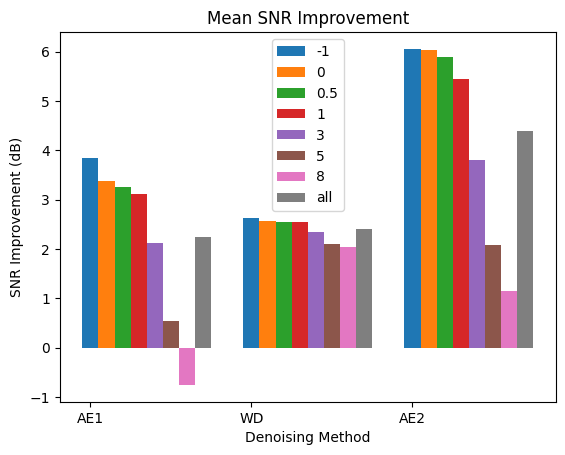

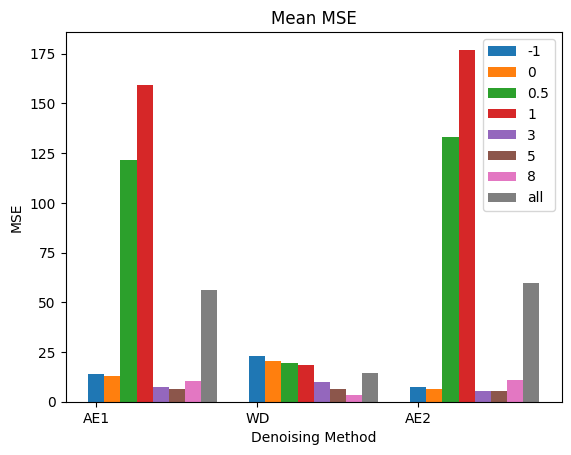

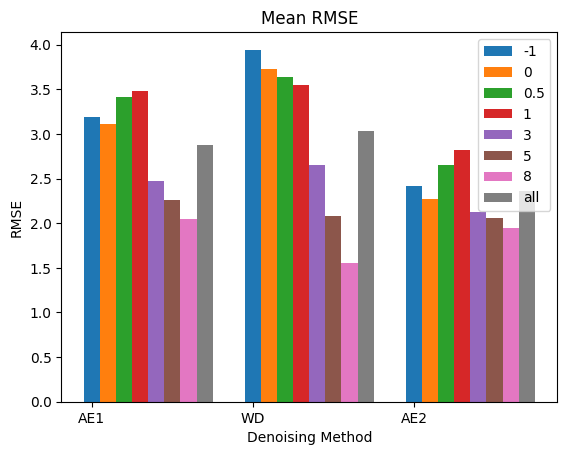

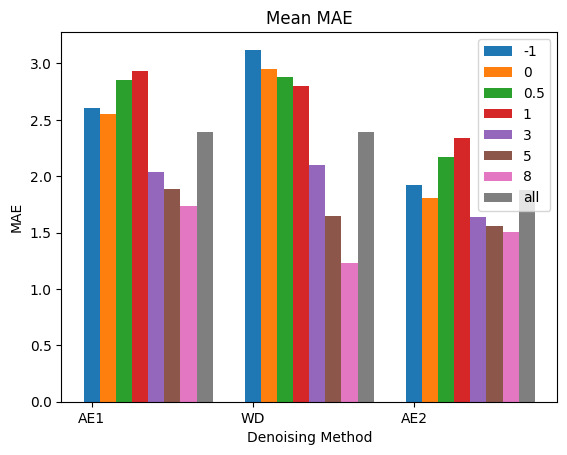

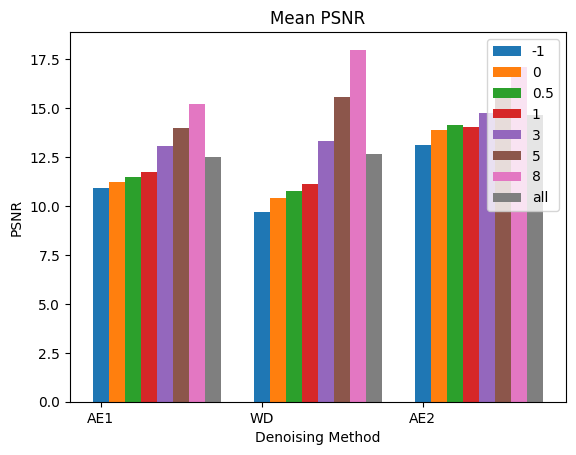

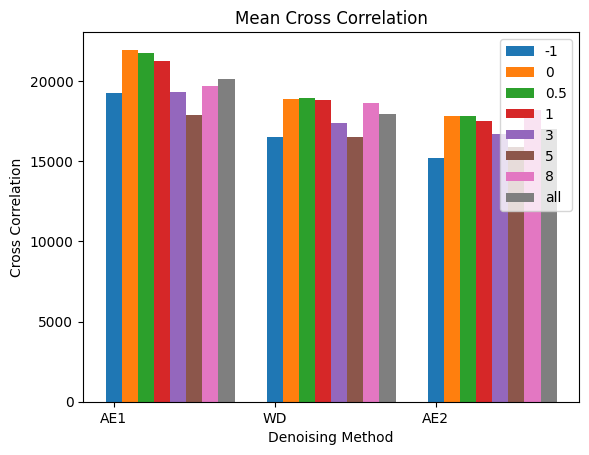

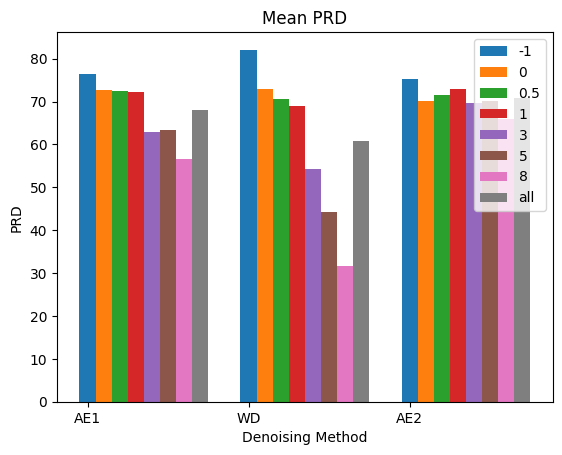

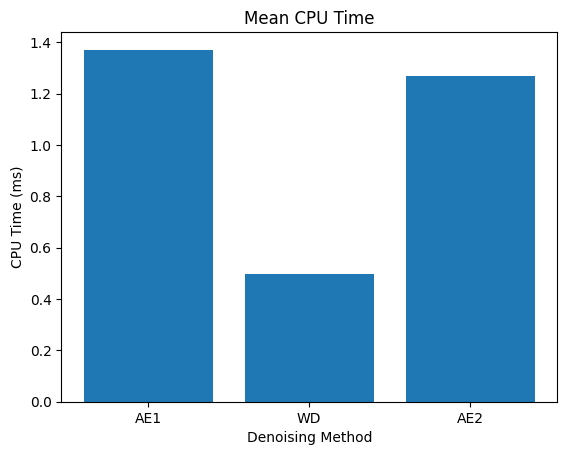

<Figure size 640x480 with 0 Axes>

In [ ]:
def reverse(x):
    return dataset.max_val * x - x * dataset.min_val + dataset.min_val

def test(config):
    
    with torch.no_grad():

        ae1 = DeNoise1(layer_size=128).to(device)
        ae1.load_state_dict(torch.load(os.path.join(model_directory, 'model_1.pth')))
        ae1.eval()

        ae2 = DeNoise2(layer_size=128).to(device)
        ae2.load_state_dict(torch.load(os.path.join(model_directory, 'model_2.pth')))
        ae2.eval()

        ae3 = DeNoise2(layer_size=128).to(device)
        # ae3.load_state_dict(torch.load(os.path.join(model_directory, 'model_3.pth')))
        ae3.eval()

        ae4 = DeNoiseNone().to(device)
        ae4.load_state_dict(torch.load(os.path.join(model_directory, 'model_4.pth')))
        ae4.eval()

        results = {}

        for method in config['methods']:
            
            results[method] = {}
            for target in test_target_snr_dbs + ['all']:
                results[method][target] = {
                    'result': [],
                    'snr_imp': [],
                    'mse': [],
                    'rmse': [],
                    'mae': [],
                    'psnr': [],
                    'xcorr': [],
                    'prd': [],
                    'cpu_time': []
                }
            i = 0
            for noise, clean in test_dataset:

                cpu_time = 0
                clean, noise, min_val, max_val = normalize(clean, noise)

                if method == 'AE1':
                    
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device)

                    cpu_time_start = time.process_time()
                    predicted = ae1(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                elif method == 'AE2':
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device)

                    cpu_time_start = time.process_time()
                    predicted = ae2(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                elif method == 'WD':
                    noise = noise.numpy()

                    cpu_time_start = time.process_time()
                    predicted = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start
                elif method == 'AE1+WD':
                    noise = noise.numpy()

                    cpu_time_start = time.process_time()
                    predicted = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                    noise = torch.from_numpy(predicted)
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device)
                    predicted = ae1(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                elif method == 'AE4':
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device)

                    cpu_time_start = time.process_time()
                    predicted = ae4(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                else:
                    break

                clean_old = clean.numpy()
                clean, noise = denormalize(clean_old, noise, min_val, max_val)
                clean, predicted = denormalize(clean_old, predicted, min_val, max_val)

                snr_data = snr(clean, noise)
                for target in test_target_snr_dbs + ['all']:
                    if (str(target) == 'all') or (snr_data > (target - 0.8) and snr_data < (target + 0.8)):
                        i += 1
                        results[method][target]['result'].append(predicted)
                        results[method][target]['snr_imp'].append([snr(clean, predicted) - snr_data])
                        results[method][target]['mse'].append([mse(clean, predicted)])
                        results[method][target]['rmse'].append([rmse(clean, predicted)])
                        results[method][target]['mae'].append([mae(clean, predicted)])
                        results[method][target]['psnr'].append([psnr(clean, predicted)])
                        results[method][target]['xcorr'].append([xcorr(clean, predicted)])
                        results[method][target]['prd'].append([prd(clean, predicted)])
                        results[method][target]['cpu_time'].append(cpu_time)
            
            print(i)
            value = 0
            print('*** ' + method + ' ***')
            print(len(results[method][value]['result']))
            print('SNR IMP ' + str(np.mean(results[method][value]['snr_imp'])))
            print('RMSE ' + str(np.mean(results[method][value]['rmse'])))
            print('PRD ' + str(np.mean(results[method][value]['prd'])))
            print('CPU TIME ' + str(np.mean(results[method][value]['cpu_time'])))
            print()

        save_results(results)


config = {
    'methods': ['AE1', 'WD', 'AE2']# , 'AE1+WD']
}

train_dataset.dataset.add_noise(test_target_snr_dbs)
test(config)

In [ ]:
train_dataset.dataset.add_noise(test_target_snr_dbs)

1.407327642072067
2103
7.882624
34.56431

2.2607563
5.1953554

-1.134176254272461
-7.553746700286865
0.5252110213041306

12.350996732711792
5.9314268827438354

8.543764
-276.239



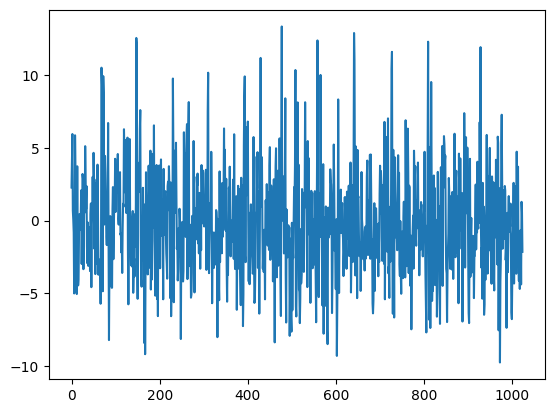

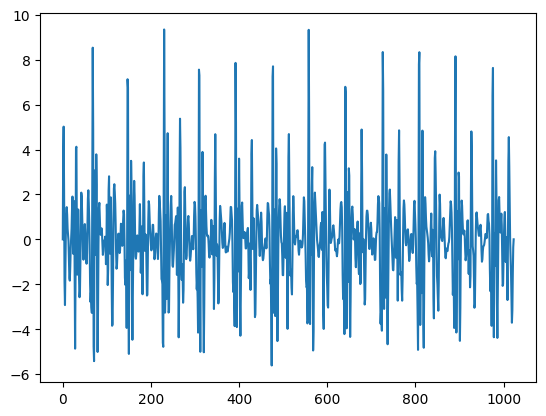

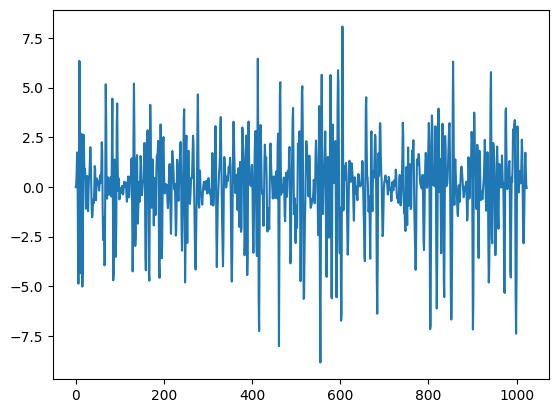

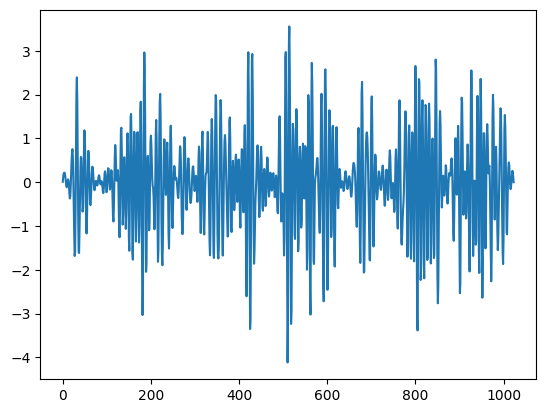

In [ ]:
model1 = DeNoise1(layer_size=128).to(device)
model1.load_state_dict(torch.load(os.path.join(model_directory, 'model_1.pth')))

model2 = DeNoise2(layer_size=128).to(device)
model2.load_state_dict(torch.load(os.path.join(model_directory, 'model_2.pth')))

model1.eval()
model2.eval()

def signaltonoise(Arr, axis=0, ddof=0):
    Arr = np.asanyarray(Arr)
    me = Arr.mean(axis)
    sd = Arr.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, me/sd)

print(signaltonoise([50, 12, 15, 34, 5], axis=0, ddof=0))

with torch.no_grad():
    
    print(len(test_dataset))
    i = random.choice(range(0, len(test_dataset)))
    noise = test_dataset[i][0]
    clean = test_dataset[i][1]

    clean, noise, min_val, max_val = normalize(clean, noise)
    clean = clean.reshape(-1, 1, segment_size_samples).to(device)
    noise = noise.reshape(-1, 1, segment_size_samples).to(device)

    predicted = model1(noise).to('cpu').reshape(segment_size_samples).numpy()
    predicted2 = model2(noise).to('cpu').reshape(segment_size_samples).numpy()
    clean_old = clean.to('cpu').reshape(segment_size_samples).numpy()
    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
    
    clean, noise = denormalize(clean_old, noise, min_val, max_val)
    clean, predicted = denormalize(clean_old, predicted, min_val, max_val)
    clean, predicted2 = denormalize(clean_old, predicted2, min_val, max_val)
    # predicted2 = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')

    from_val = 0
    to_val = 1024

    print(mse(clean, noise))
    print(mse(clean, predicted))
    print()

    print(mae(clean, noise))
    print(mae(clean, predicted))
    print()

    print(snr(clean, noise))
    print(snr(clean, predicted))
    print(snr(clean, predicted2))
    print()

    print(psnr(clean, noise))
    print(psnr(clean, predicted))
    print()

    print(xcorr(clean, noise))
    print(xcorr(clean, predicted))
    print()
    
    time_from = 0
    time_to = 1024

    plt.plot(range(time_to)[time_from:time_to], noise[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], bandpass(clean)[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], bandpass(predicted)[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], bandpass(predicted2)[time_from:time_to])
    plt.show()

    torch.cuda.empty_cache()